In [1]:
# uniform

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 100,
        x_rate = 0.5,
        m_rate = 0.5,
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.1,
        grow_factor = 0.1,
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    

C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.8333333333333334, Loss: 0.6024334518997757
Checkpoint 200, Accuracy: 0.8518518518518519, Loss: 0.5747648874918619
Checkpoint 300, Accuracy: 0.8518518518518519, Loss: 0.5723596502233435
Checkpoint 400, Accuracy: 0.8580246913580247, Loss: 0.5704364070185909
Checkpoint 500, Accuracy: 0.8641975308641975, Loss: 0.5690272649129232


C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))


In [10]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 1. 0.] <-> [[0.02673721]
 [0.40955102]
 [0.56371176]]
[1. 0. 0.] <-> [[0.34150887]
 [0.34102333]
 [0.31746775]]
[1. 0. 0.] <-> [[0.9008793 ]
 [0.06759669]
 [0.03152395]]
[1. 0. 0.] <-> [[0.8996355 ]
 [0.06836092]
 [0.03200356]]
[0. 0. 1.] <-> [[0.0094453 ]
 [0.35785624]
 [0.6326985 ]]
[0. 1. 0.] <-> [[0.4652918 ]
 [0.28088853]
 [0.2538197 ]]
[1. 0. 0.] <-> [[0.87615365]
 [0.08352455]
 [0.04032182]]
[1. 0. 0.] <-> [[0.8973973 ]
 [0.06969475]
 [0.03290795]]
[1. 0. 0.] <-> [[0.9024284 ]
 [0.06661953]
 [0.03095214]]
[1. 0. 0.] <-> [[0.5519943 ]
 [0.25673297]
 [0.1912727 ]]
[0. 1. 0.] <-> [[0.5253694 ]
 [0.25634342]
 [0.21828723]]
[1. 0. 0.] <-> [[0.8987109 ]
 [0.06891511]
 [0.03237395]]
[1. 0. 0.] <-> [[0.89236856]
 [0.07279071]
 [0.03484071]]
[1. 0. 0.] <-> [[0.5550705 ]
 [0.2575708 ]
 [0.18735874]]
[0. 1. 0.] <-> [[0.03906403]
 [0.42383555]
 [0.5371005 ]]
[1. 0. 0.] <-> [[0.89169973]
 [0.07321692]
 [0.03508344]]
[1. 0. 0.] <-> [[0.8999795 ]
 [0.06815191]
 [0.03186863]]
[1. 0. 0.] <->

C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))


In [12]:
# Testing Performance

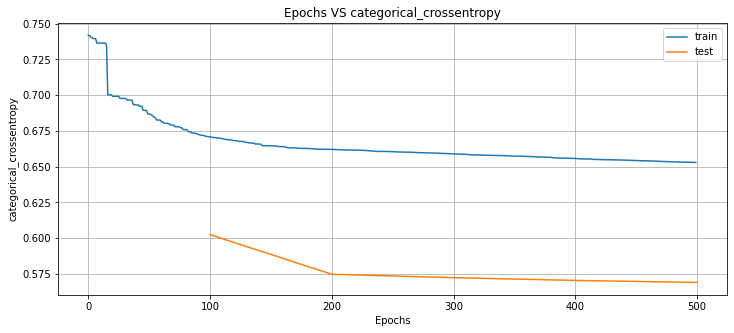

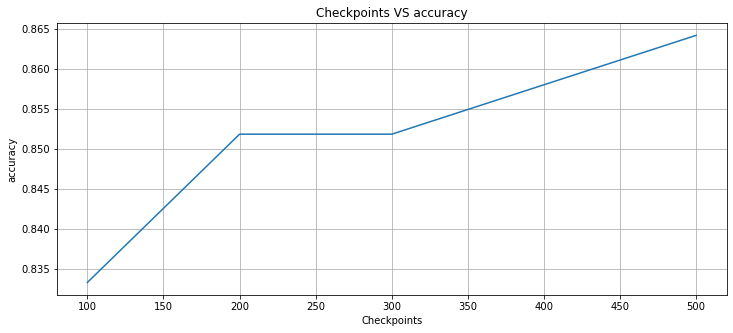

In [13]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8333333333333334, 'mean_square_error': 2.864826471063561, 'categorical_crossentropy': 0.6024334518997757, 'precision': 0.75, 'recall': 0.75, 'f1': 0.75, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 12, 'tn_hit': 16, 'fn_hit': 5}, 1: {'tp_hit': 6, 'fp_hit': 15, 'tn_hit': 78, 'fn_hit': 9}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 13}}, 'checkpoint': 100} 


{'accuracy': 0.8518518518518519, 'mean_square_error': 2.881832239800929, 'categorical_crossentropy': 0.5747648874918619, 'precision': 0.7777777777777778, 'recall': 0.7777777777777778, 'f1': 0.7777777777777778, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 14, 'tn_hit': 14, 'fn_hit': 3}, 1: {'tp_hit': 0, 'fp_hit': 5, 'tn_hit': 88, 'fn_hit': 15}, 2: {'tp_hit': 7, 'fp_hit': 5, 'tn_hit': 90, 'fn_hit': 6}}, 'checkpoint': 200} 


{'accuracy': 0.8518518518518519, 'mean_square_error': 2.876522633963893, 'categorical_crossentropy': 0.5723596502233435, 'precision': 0.7777777777777778, 'recall': 0.77777777777

In [15]:
print(model)

Layer 1
Neuron 0: weights:
[[ 2.8256416]
 [-2.4310026]
 [-2.4088116]
 [ 1.6342615]
 [ 1.534855 ]]
 bias: [-3.]

Neuron 1: weights:
[[-2.4938858 ]
 [-2.2935553 ]
 [-2.9530888 ]
 [ 0.23841716]
 [-3.        ]]
 bias: [-2.749702]

Neuron 2: weights:
[[-2.7211962]
 [-2.8233418]
 [-2.1619442]
 [ 2.0441704]
 [-1.0270145]]
 bias: [-0.56216395]

Neuron 3: weights:
[[ 2.629039 ]
 [-1.4487476]
 [-2.4748123]
 [ 0.8169893]
 [-1.2866465]]
 bias: [2.8788793]

$
Layer 2
Neuron 0: weights:
[[-2.978511 ]
 [-0.9038075]
 [ 1.5260061]
 [ 2.8386996]]
 bias: [0.55568635]

Neuron 1: weights:
[[ 0.37025115]
 [-3.        ]
 [ 2.1071854 ]
 [ 1.3594308 ]]
 bias: [0.9055066]

Neuron 2: weights:
[[ 1.4016458 ]
 [-2.38864   ]
 [ 0.87786037]
 [ 1.6443454 ]]
 bias: [0.46335286]

$

